In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import utils
from scipy.stats import skew
import math
import re
from collections import deque

This notebook attempts to provide an overview about insights on data understanding of the provided dataset.
This includes checking anomalies of the dataset, spotting errors and potential concerns of the data.
* Objective: Predict vehicle sale prices (Sold_Amount)
* Constraints (not applicable): AvgWholesale, AvgRetail, GoodWholesale, GoodRetail, TradeMin, TradeMax, PrivateMax

---

# Content:
1. Data Entry
2. Data preprocessing
    - 2.1 Evaluating Target Variables
    - 2.2 Removing Field of Constraints
    - 2.3 Handling NULL Values
    - 2.4 Handling Potential Similar Columns
    - 2.5 Removing Special Characters
    - 2.6 Correlation Analysis
    - 2.7 Imputation
        - 2.7.1 Binning Data
        - 2.7.2 Numerical Data
        - 2.7.3 Categorical Data
    - 2.8 Feature Selection
3. Finishing Touch

---

# 1. Data Entry

In [2]:
# load the data set
ds = pd.read_table('DatiumSample.rpt')

C:\Users\Kevin Teng\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: DtypeWarning: Columns (27,91) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [3]:
ds.head()

,Make,Model,MakeCode,FamilyCode,YearGroup,MonthGroup,SequenceNum,Description,CurrentRelease,ImportFlag,...,PrivateMax,NewPrice,Colour,Branch,SaleCategory,Sold_Date,Compliance_Date,Age_Comp_Months,KM,Sold_Amount
0,Holden,Commodore,HOLD,COMMODO,2008,0,0,VE Omega Sedan 4dr. Auto 4sp 3.6i,F,L,...,5500.0,34790.0,White,Perth (WA),Auction,2015-11-03 00:00:00.000,02/2008,93.0,227878.0,2000.0
1,Holden,Commodore,HOLD,COMMODO,1993,7,41,VR Executive Wagon 5dr. Auto 4sp 3.8i,F,L,...,2000.0,27978.0,Red,Belmore (NSW),Auction,2000-10-18 00:00:00.000,08/1993,86.0,153091.0,6800.0
2,Toyota,RAV4,TOYO,RAV4,2012,0,6,ACA33R MY12 CV Wagon 5dr Man 5sp 4x4 2.4i,F,L,...,15800.0,31990.0,040 - Glacier White (T),Sunshine (VIC),Dealer Only Auction,2014-02-05 00:00:00.000,10/2012,16.0,27374.0,22900.0
3,Holden,Commodore,HOLD,COMMODO,2007,0,11,VZ@VE MY07 Executive Wagon 5dr. Auto 4sp 3.6i,F,L,...,4800.0,35990.0,Quicksilver,Belmore (NSW),Auction,2011-01-10 00:00:00.000,01/2007,48.0,99452.0,10500.0
4,Toyota,Tarago,TOYO,TARAGO,2007,0,0,ACR50R GLi Wagon 8st 5dr Spts Auto 4sp 2.4i,F,L,...,12400.0,49490.0,Silver,Hobart (TAS),Special Fixed Price,2009-05-23 00:00:00.000,01/2007,28.0,44355.0,31320.0


Check the number of rows and columns 

In [4]:
rows, cols = ds.shape
print("There are {} rows.".format(rows))
print("There are {} columns.".format(cols))

There are 62192 rows.
There are 130 columns.


In [5]:
# check data type
ds.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62192 entries, 0 to 62191
Data columns (total 130 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Make                            object 
 1   Model                           object 
 2   MakeCode                        object 
 3   FamilyCode                      object 
 4   YearGroup                       int64  
 5   MonthGroup                      int64  
 6   SequenceNum                     int64  
 7   Description                     object 
 8   CurrentRelease                  object 
 9   ImportFlag                      object 
 10  LimitedEdition                  object 
 11  Series                          object 
 12  SeriesModelYear                 object 
 13  BadgeDescription                object 
 14  BadgeSecondaryDescription       object 
 15  BodyStyleDescription            object 
 16  BodyConfigDescription           object 
 17  WheelBaseConfig               

---

# 2. Data Preprocessing <a class="anchor" id="dataPre"></a>
This section attempts to improve the quality of the data via finding the caveats of the data set,
manipulating and dropping data before the input pipeline of the model. This section also deals with feature selections where we attempt to purge features that are least relevent to the traget variable.

## 2.1 Evaluating Target Variables
Since the objective is to predict the vehicle sold price, which is "Sold_Amount".
It is crucial to check if "Sold_Amount" is valid for all records, else there would be no target for predictive model.

In [6]:
ds['Sold_Amount'].describe()

count     62188.000000
mean      16723.225357
std       10541.480928
min           0.000000
25%       10600.000000
50%       15151.500000
75%       20800.000000
max      317000.000000
Name: Sold_Amount, dtype: float64

In [7]:
print("Number of records with NULL price: ", ds['Sold_Amount'].isna().sum())

Number of records with NULL price:  4


In [8]:
# collect the row indices where pice is NULL
price_isna_idx = np.where(ds['Sold_Amount'].isna()==True)[0]
# remove the rows where target price is not available 
ds.drop(price_isna_idx, axis=0, inplace=True)
print("Number of records with NULL price: ", ds['Sold_Amount'].isna().sum())
print("-"*50)
rows, cols = ds.shape
print("There are {} rows.".format(rows))
print("There are {} columns.".format(cols))

Number of records with NULL price:  0
--------------------------------------------------
There are 62188 rows.
There are 130 columns.


Before clipping the values of the target variables 

Skewness:  3.6786925118862657


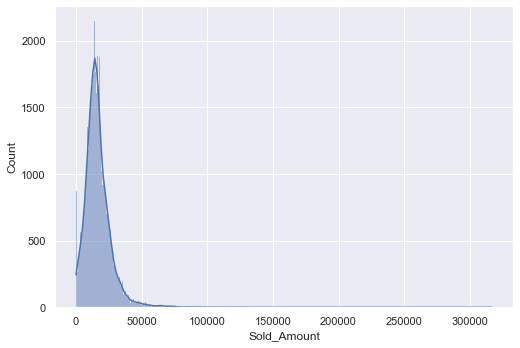

In [9]:
sns.set_theme()
price_dist = sns.displot(ds['Sold_Amount'], kde=True)
price_dist.fig.set_size_inches(8,5)
print("Skewness: ", ds['Sold_Amount'].skew())

Looking at the distribution of car price, the distribution is right-skewed with some outliers on car price >50000

Remove outliers by clipping the price value up to 99th percentile

In [10]:
ds = ds[ds.Sold_Amount < ds.Sold_Amount.quantile(0.99)]

In [11]:
ds['Sold_Amount'].describe()

count    61560.000000
mean     16155.338804
std       8542.599992
min          0.000000
25%      10600.000000
50%      15000.000000
75%      20500.000000
max      53400.000000
Name: Sold_Amount, dtype: float64

Skewness:  0.9007284076100697


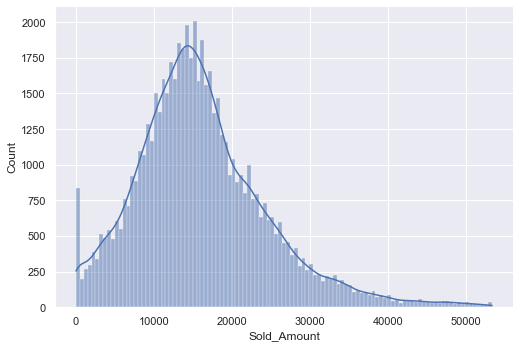

In [12]:
sns.set_theme()
price_dist = sns.displot(ds['Sold_Amount'], kde=True)
price_dist.fig.set_size_inches(8,5)
print("Skewness: ", ds['Sold_Amount'].skew())

The distribution looks much better. Alternatively, lets see how log transformation will do to the distribution. 

Skewness:  -5.756966511703112


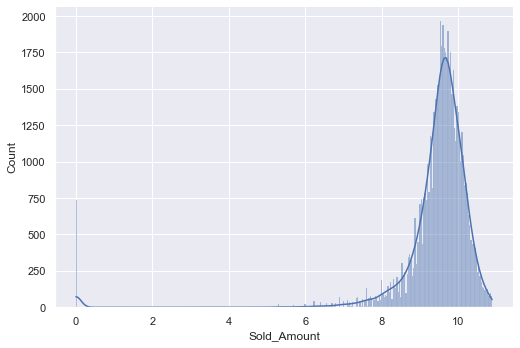

In [13]:
# using log1p transformation with apply log(1+x) to reduce error for min. value of 0 
y = ds['Sold_Amount'].copy()
log_y = np.log1p(y)
price_dist = sns.displot(log_y, kde=True)
price_dist.fig.set_size_inches(8,5)
print("Skewness: ", log_y.skew())

In [14]:
log_y.describe()

count    61560.000000
mean         9.430467
std          1.213001
min          0.000000
25%          9.268704
50%          9.615872
75%          9.928229
max         10.885585
Name: Sold_Amount, dtype: float64

In [15]:
# check duplicate rows
print("Number of duplicate rows: ",ds.duplicated().sum())

Number of duplicate rows:  0


---

## 2.2 Removing Field of Constraints
Drop inapplicable field: 'AvgWholesale', 'AvgRetail', 'GoodWholesale', 'GoodRetail', 'TradeMin', 'TradeMax', 'PrivateMax'

In [16]:
# field to be dropped
constraints = ['AvgWholesale', 'AvgRetail', 'GoodWholesale', 
               'GoodRetail', 'TradeMin', 'TradeMax', 'PrivateMax'] 
ds.drop(columns = constraints, inplace = True)
# sanity check for the dimensionality of the data set
print("There are {} columns.".format(ds.shape[1]))

There are 123 columns.


---

## 2.3 Handling NULL Values
In this part, we deal with fields having NULL values exceeding a certain threshold.

In [17]:
# In this part, the number of missing values for each fields is validated and ranked.
null_count_arr = ds.isna().sum()
print(null_count_arr.sort_values(ascending=False))

AltEngTorqueFrom       61560
QuickChargeMins        61560
QuickChargeVoltage     61560
TopSpeedElectricEng    61559
NormalChargeMins       61558
                       ...  
EngineDescription          0
EngineSize                 0
DoorNum                    0
GearTypeDescription        0
Make                       0
Length: 123, dtype: int64


Text(0.5, 1.0, 'Percentage of Missing Values by Features')

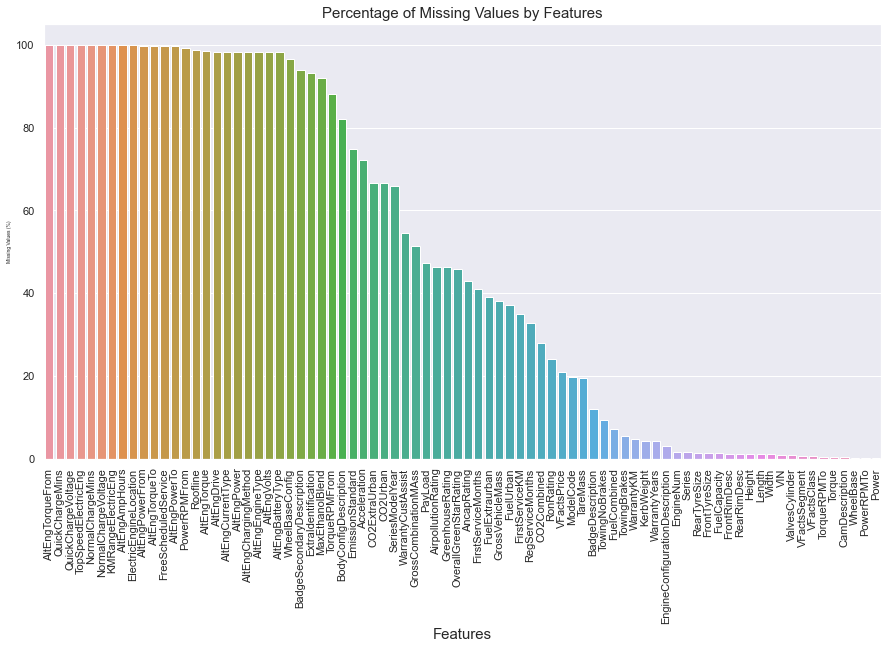

In [18]:
# plot the distribution of missing values by top 80 features 
null_ratio = (null_count_arr.sort_values(ascending=False)[:80]/ds.shape[0])*100
plt.figure(figsize=(15,8))
plt.xticks(rotation = '90')
sns.barplot(x = null_ratio.index, y = null_ratio)
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Missing Values (%)', fontsize = 5)
plt.title('Percentage of Missing Values by Features', fontsize = 15)

By observing the above information, there are quite a number of fields that contain 
NULL values equivalent to the number of records. These fields will not provide 
information to the predictive model. Therefore, we specify a certain threshold where
the NULL values exceed a certain percentage of the total records, the field is concurrently dropped. In this case, we defined the threshold percentage as 80%. 

In [19]:
# percentage of NULL values that exceed the total number of records  
pct = 0.8
# get the index where NULL value is larger than certain (pct) of the records
null_thr_idx = np.where(null_count_arr > int(ds.shape[0]*pct))[0]
print("Number of columns to be dropped: ", null_thr_idx.shape[0])

Number of columns to be dropped:  29


Dropping the fields of NULL value exceeding 80% of the total records.
Drop 'Description' field because it gives a little insight and it is not helpful for predicting the target price. 

In [20]:
# check which particular field will need to be dropped
# by mapping the indices to the respective field 
ds.drop(columns = np.take(ds.columns, null_thr_idx).tolist(), inplace = True)
# ds['is_sport'] = ds['Description'].apply(lambda x: 1 if 'sport' in x.lower() else 0)
ds.drop(columns = "Description", inplace = True)
print("There are {} columns.".format(ds.shape[1]))

There are 93 columns.


---

## 2.4 Handling Potential Similar Columns
Remove certain fields that are short form representations of a given fields these field contains the keyword "Code" inside:
- Example:  
"MakeCode" field is the abbreviation of "Make"  
"FamilyCode" field is the abbreviation of "Model"  
"DriveCode" field is the abbreviation of "DriveDescription"


In [21]:
# search fields that contains wildcard "Code"
match_id_list = utils.string_search(ds.columns.to_list(), "*Code")
print([ds.columns.to_list()[i] for i in match_id_list])

['MakeCode', 'FamilyCode', 'DriveCode', 'ModelCode']


In [22]:
# "ModelCode" is omitted because the column is unique
ds.drop(columns = ['MakeCode', 'FamilyCode', 'DriveCode'], inplace = True)

---

## 2.5 Removing Special Characters
After dropping all irrelevant fields, we need to run a check for potential special characters inside records. Intuitively at first glance, the field for 'EngineNum' contains special characters, such as #, -, ?. Special characters such as "., /, :, -, <, >, (, )" should be omiited.
- "." is used in decimals
- "/" is used in date or special representations
- ":" is used in timestamp
- "<" is symbol as less than 
- ">" is symbol as larger than 
- "()" brackets

In [23]:
print(ds['EngineNum'])

0         HBA04 ######
1            VH-######
2          2AZ-#######
3        HBA06 #######
4          2AZ-#######
             ...      
62186      P5AT-######
62187      JGSW2M#####
62188      JGSWYA#####
62189      4B11??-####
62190    Z22D1 ######K
Name: EngineNum, Length: 61560, dtype: object


In [24]:
# to do! better way of removing special character 
special_char = "[^A-Za-z0-9:/.<()>\s]"
# let's check which field have special characters and how many rows of it
special_char_field = utils.special_char_field_checker(ds, special_char)

'Make' has 533 rows with special characters.
'Model' has 1312 rows with special characters.
'Series' has 379 rows with special characters.
'BadgeDescription' has 2383 rows with special characters.
'GearTypeDescription' has 79 rows with special characters.
'GearLocationDescription' has 1738 rows with special characters.
'FuelTypeDescription' has 47608 rows with special characters.
'CamDescription' has 587 rows with special characters.
'EngineTypeDescription' has 1100 rows with special characters.
'FuelDeliveryDescription' has 48448 rows with special characters.
'VIN' has 58450 rows with special characters.
'ModelCode' has 27838 rows with special characters.
'EngineConfigurationDescription' has 40332 rows with special characters.
'EngineLocation' has 21 rows with special characters.
'EngineNum' has 59013 rows with special characters.
'WarrantyCustAssist' has 8 rows with special characters.
'VFactsSegment' has 208 rows with special characters.
'VFactsPrice' has 48244 rows with special cha

Proceed to remove the special character for each fields and do a sanity check!

In [25]:
# remove special character for the appointed column 
for f in special_char_field:
    # for some reason, .replace() works on data type 'object' but not 'string'
    ds[f].replace(special_char, '', regex=True, inplace=True) 
# sanity check    
special_char_field = utils.special_char_field_checker(ds, special_char)
# no output means that special character has been remove!
# now we validate the records after removing special characters
print(ds['EngineNum'])

0         HBA04 
1             VH
2            2AZ
3         HBA06 
4            2AZ
          ...   
62186       P5AT
62187     JGSW2M
62188     JGSWYA
62189       4B11
62190    Z22D1 K
Name: EngineNum, Length: 61560, dtype: object


---


## 2.6 Correlation Analysis
This section will attempt to visualise the categorical data with correlation matrix on heatmap
and trim the highly correlated features.

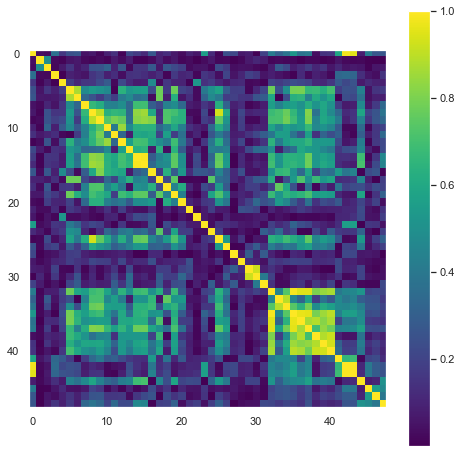

In [26]:
# use Pearson method for correlation
cor_matrix = ds.corr('pearson').abs()
plt.figure(figsize=(8,8))
plt.imshow(cor_matrix, cmap = 'viridis')
plt.colorbar()
plt.grid(False)

Check multicollinearity among the independent variable by plotting the heatmap of correlation matrix of the numerical data.
From the distribution of the heatmap, we can observe that there are some variables that has high correlation dependencies.
We try to trim high correlation dependencies given a threshold.

In [27]:
# since correlation matrices are symmetrical, we take the upper triangle part to create masking
upper_tri_mask = np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool)
upper_tri = cor_matrix.where(upper_tri_mask)
# retrieve the column that has correlation greater than a given threshold
high_cor_col = [col for col in upper_tri.columns if any(upper_tri[col]>0.8)]
print('Fields with high correlation:')
print(high_cor_col)
print()
print("The number of column to be dropped: ", len(high_cor_col))
# drop columns with high correlation!
ds.drop(columns = high_cor_col, inplace = True)

Fields with high correlation:
['Cylinders', 'GrossVehicleMass', 'Length', 'KerbWeight', 'TareMass', 'PayLoad', 'TowingBrakes', 'FirstServiceMonths', 'OverallGreenStarRating', 'CO2Combined', 'CO2Urban', 'CO2ExtraUrban', 'FuelUrban', 'FuelExtraurban', 'FuelCombined', 'AverageKM', 'GoodKM']

The number of column to be dropped:  17


C:\Temp/ipykernel_30912/464765284.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri_mask = np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool)


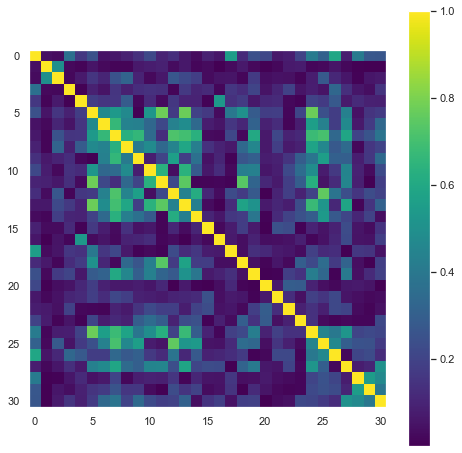

In [28]:
# plot post processed correlation matrix
post_cor_matrix = ds.corr('pearson').abs()
plt.figure(figsize=(8,8))
plt.imshow(post_cor_matrix, cmap = 'viridis')
plt.colorbar()
plt.grid(False)

As observed from the post processed correlation matrix, the high correlation hot spots has been mitigated.

In [29]:
# Retrieve the number of categorical fields and numerical fields
# field indices where column is categorical
categorical_col_idx = np.where(ds.dtypes == object)[0]
# field indices where column is numerical
numerical_col_idx = np.where(ds.dtypes != object)[0]
print("Number of categorical fields: ",categorical_col_idx.shape[0])
print("Number of numerical fields: ",numerical_col_idx.shape[0])

Number of categorical fields:  42
Number of numerical fields:  31


---

## 2.7 Imputation

This section attempts to replace missing data with substitution.
- Mode for categorical data 
- Mean for numerical data 

In [30]:
ds.dtypes

Make                object
Model               object
YearGroup            int64
MonthGroup           int64
SequenceNum          int64
                    ...   
Sold_Date           object
Compliance_Date     object
Age_Comp_Months    float64
KM                 float64
Sold_Amount        float64
Length: 73, dtype: object

We notice that some data fields are of type 'object' which is a mixed of string and numerical data types.  
For ease of manipulation the categorical fields of 'object' type should be converted to 'string'.

Further cleaning for WarrantyKM, we do not want negative values in it.

In [31]:
ds['WarrantyKM'] = ds['WarrantyKM'].apply(lambda x: utils.check_warranty_km(x))
ds['WarrantyKM'].value_counts()

100000.0     49625
130000.0      2078
50000.0        560
80000.0        180
200000.0       178
160000.0       175
60000.0        137
40000.0         16
20000.0         13
1000000.0       12
150000.0        11
180000.0         4
Name: WarrantyKM, dtype: int64

### 2.7.1 Binning Data  

In [32]:
numeric_col = ds.dtypes[ds.dtypes != object].index
numeric_col_unique = {k: len(ds[k].unique()) for k in numeric_col}
print(numeric_col_unique)

{'YearGroup': 44, 'MonthGroup': 13, 'SequenceNum': 102, 'GearNum': 10, 'DoorNum': 4, 'EngineSize': 420, 'FuelCapacity': 85, 'GrossCombinationMAss': 685, 'WheelBase': 357, 'Height': 492, 'Width': 299, 'Power': 219, 'PowerRPMTo': 64, 'Torque': 328, 'TorqueRPMTo': 86, 'RonRating': 4, 'SeatCapacity': 13, 'ValvesCylinder': 5, 'Acceleration': 129, 'TowingNoBrakes': 75, 'WarrantyYears': 7, 'WarrantyKM': 13, 'FirstServiceKM': 20, 'RegServiceMonths': 7, 'GreenhouseRating': 18, 'AirpollutionRating': 14, 'AncapRating': 6, 'NewPrice': 4305, 'Age_Comp_Months': 291, 'KM': 51632, 'Sold_Amount': 3450}


There are some features with fixed values, hence, we need to convert them to categorical as well.

In [33]:
tmp_col = ['YearGroup',
 'MonthGroup',
 'SequenceNum',
 'GearNum',
 'DoorNum',
 'FuelCapacity',
 'SeatCapacity',
 'ValvesCylinder',
 'TowingNoBrakes', # to  be observed
 'WarrantyYears',
 'FirstServiceKM',
 'RegServiceMonths',
 'WarrantyKM']

# needed to convert categorical columns from object to strings in order for ease of manipulation
categorical_col_idx = np.where(ds.dtypes == object)[0]
cols_name = [name for name in ds.columns]
categorical_cols = [cols_name[i] for i in categorical_col_idx] + tmp_col
ds[categorical_cols] = ds[categorical_cols].astype('string')

### 2.7.2 Numerical Data

In [34]:
# fill numerical data of NULL value with mean of the data 
numeric_cols = [c for c in ds.columns if c not in categorical_cols]
# fill NULL value with dependencies on 'Make' column 
ds[numeric_cols] = ds.groupby(['Make'])[numeric_cols]\
    .transform(lambda x: x.fillna(x.mean()))

In [35]:
null_count_arr03 = ds[[c for c in ds.columns if c not in categorical_cols]].isna().sum()
print(null_count_arr03.sort_values(ascending=False))

AirpollutionRating      224
GreenhouseRating        224
Acceleration            203
AncapRating             195
RonRating               160
GrossCombinationMAss     40
TorqueRPMTo               2
Width                     2
WheelBase                 2
Height                    2
Torque                    2
PowerRPMTo                2
Power                     1
Sold_Amount               0
KM                        0
NewPrice                  0
Age_Comp_Months           0
EngineSize                0
dtype: int64


In [36]:
ds.fillna(ds.mean(), inplace=True)

### 2.7.3 Categorical Data

In [37]:
null_count_arr04 = ds.isna().sum()
# gather the indices of categorical data records
null_thr_idx02 = np.where(null_count_arr04!=0)[0]
categorical_field = np.take(ds.columns, null_thr_idx02)
print('Categorical fields with NULL values:')
print()
print(categorical_field)

Categorical fields with NULL values:

Index(['Series', 'SeriesModelYear', 'BadgeDescription',
       'GearLocationDescription', 'GearNum', 'CamDescription', 'FuelCapacity',
       'MethodOfDeliveryDescription', 'VIN', 'SeatCapacity', 'ModelCode',
       'ValvesCylinder', 'EngineConfigurationDescription', 'EngineLocation',
       'EngineNum', 'FrontTyreSize', 'RearTyreSize', 'FrontRimDesc',
       'RearRimDesc', 'TowingNoBrakes', 'WarrantyCustAssist', 'WarrantyYears',
       'WarrantyKM', 'FirstServiceKM', 'RegServiceMonths', 'EmissionStandard',
       'VFactsClass', 'VFactsSegment', 'VFactsPrice', 'Colour',
       'Compliance_Date'],
      dtype='object')


In [38]:
# replace the categorical data with mode of each field respectively
for n in categorical_cols:
    ds[n].fillna(ds[n].mode()[0], inplace=True)

In [39]:
# sanity check if the method works
print(np.where(ds.isna().sum()!=0)[0])

[]


Empty list means that there is no NULL value inside the dataset!

---

## 2.8 Skewness of Numerical Data

In [40]:
# retrieve numerical data columns
numeric_cols = [c for c in ds.columns if c not in categorical_cols]
# ranked skewed columns
skewed_cols = ds[numeric_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
skewed_df = pd.DataFrame({'Skewness': skewed_cols})
skewed_df.head(10)

,Skewness
KM,32.256132
Age_Comp_Months,6.735797
RonRating,3.905651
NewPrice,3.365317
Acceleration,2.398004
Height,1.484907
Sold_Amount,0.900706
WheelBase,0.689701
Power,0.493070
EngineSize,0.372769


In [41]:
# choose top four right skewed columns for log transformation
right_skewed_cols = skewed_cols.index[0:4]
for r in right_skewed_cols:
    ds[right_skewed_cols] = np.log1p(ds[right_skewed_cols])

## 2.9 Feature Selection

Check the number of unique classes for categorical fields. This could be useful for feature selections where we can merge or remove the features.

In [42]:
cols_name = [name for name in ds.columns]
categorical_cols = [cols_name[i] for i in categorical_col_idx]
# dictionary to store number of classes for each categorical fields
n_class = {}
for c in categorical_cols:
    val, count = np.unique(ds[c], return_counts=True)
    n_class[c]= len(count)
print(n_class)

{'Make': 50, 'Model': 611, 'CurrentRelease': 2, 'ImportFlag': 1, 'LimitedEdition': 2, 'Series': 1130, 'SeriesModelYear': 50, 'BadgeDescription': 714, 'BodyStyleDescription': 17, 'DriveDescription': 7, 'GearTypeDescription': 8, 'GearLocationDescription': 7, 'EngineDescription': 63, 'FuelTypeDescription': 6, 'InductionDescription': 7, 'OptionCategory': 6, 'CamDescription': 11, 'EngineTypeDescription': 3, 'FuelDeliveryDescription': 7, 'MethodOfDeliveryDescription': 3, 'VIN': 4543, 'ModelCode': 4290, 'BuildCountryOriginDescription': 31, 'EngineCycleDescription': 2, 'EngineConfigurationDescription': 9, 'EngineLocation': 3, 'EngineNum': 1483, 'FrontTyreSize': 299, 'RearTyreSize': 315, 'FrontRimDesc': 73, 'RearRimDesc': 83, 'WarrantyCustAssist': 75, 'EmissionStandard': 5, 'VFactsClass': 4, 'VFactsSegment': 14, 'VFactsPrice': 17, 'IsPPlateApproved': 2, 'Colour': 1099, 'Branch': 21, 'SaleCategory': 6, 'Sold_Date': 5431, 'Compliance_Date': 433}


notice that there is only 1 unique class for 'ImportFlag' hence we dropped it!

In [43]:
ds = ds.drop(columns=['ImportFlag'])

From the categorical fields, it is observed that there are some features with more than 100 classes. This will cause problem for feature encoding when we use one hot encoding and get_dummies() from Pandas. By using get_dummies() from Pandas this will lead to a whooping of 22k features! (See below). This will be computational expensive to train. 
  
Strategy:
- Use label encoding
- Prune features for better representation 

In [44]:
categorical_col_idx = np.where(ds.dtypes == 'string')[0]
cols_name = [name for name in ds.columns]
categorical_cols = [cols_name[i] for i in categorical_col_idx] + tmp_col
df = pd.get_dummies(ds, columns = categorical_cols)
df.head()

,EngineSize,GrossCombinationMAss,WheelBase,Height,Width,Power,PowerRPMTo,Torque,TorqueRPMTo,RonRating,...,WarrantyKM_130000.0,WarrantyKM_150000.0,WarrantyKM_160000.0,WarrantyKM_180000.0,WarrantyKM_20000.0,WarrantyKM_200000.0,WarrantyKM_40000.0,WarrantyKM_50000.0,WarrantyKM_60000.0,WarrantyKM_80000.0
0,3565,4580.623525,2915.0,1476.0,1899.0,180.0,6000.0,330.0,2600.0,0.691380,...,0,0,0,0,0,0,0,0,0,0
1,3791,4580.623525,2822.0,1478.0,1794.0,130.0,4800.0,295.0,3200.0,0.691399,...,0,0,0,0,0,0,0,0,0,0
2,2362,3560.000000,2660.0,1695.0,1815.0,125.0,6000.0,224.0,4000.0,0.691380,...,0,0,0,0,0,0,0,0,0,0
3,3565,4580.623525,2938.0,1527.0,1847.0,172.0,6000.0,320.0,2800.0,0.691380,...,0,0,0,0,0,0,0,0,0,0
4,2362,4119.877399,2950.0,1750.0,1800.0,125.0,6000.0,224.0,4000.0,0.691380,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# lets pick a few features that exceed unique class of 100 and try to interpret them
# retrieve the indices of classes from the dictionary where values exceeded 100 
class_100_idx = np.where(np.array(list(n_class.values()))>100)[0]
print([list(n_class)[i] for i in class_100_idx])

['Model', 'Series', 'BadgeDescription', 'VIN', 'ModelCode', 'EngineNum', 'FrontTyreSize', 'RearTyreSize', 'Colour', 'Sold_Date', 'Compliance_Date']


Interpretation: (tick sign means the features will be dropped) 
- [ ] 'Model', 'Series', 'BadgeDescription': are good indications for the car and it is assumed that it will contribute to the car price prediction, so it will not be dropped.
- [x] 'VIN': is Vehical Identification Number which is unique for specific automobile. We assume that there are other supporting features for this field and it will be dropped.
- [x] 'ModelCode' : We assumed that this will not be a helpful feature and it will be dropped.
- [x] 'EngineNum': Noisy data and too hard to be cleaned, it will be dropped 
- [x] 'FontTyreSize', 'RearTyreSize': Since every car will have a font and rear criterion, we can aggregrate them in a column as 'FontRearTyreSize'. In this case, similar operatin will be done on 'FrontRimDesc' and 'RearRimDesc'.
- [ ] 'Colour': Colour of choice is an influencing factor and there are many colour spectrum, therefore this feature will be retained.
- [x] 'Sold_Date': Should be dropped, because it will not affect the price. 
* [x] 'Compliance_Date': To be dropped as well.

In [46]:
# if front and rear tyre size are the same, we retain the tyre size spec
# else, we replace it with the string concatenation of front tyre size + rear tyre size 
# create mask 
front_rear_tyre_size_mask = np.where(np.array(ds['FrontTyreSize'] == ds['RearTyreSize']) == True, 
                                     1, 0)
front_rear_tyre_size = np.where(front_rear_tyre_size_mask == 1,
                                ds['FrontTyreSize'], 
                                ds['FrontTyreSize'] + '+' + ds['RearTyreSize'])
# similar to front and rear rim desc 
# create mask
front_rear_rim_desc_mask = np.where(np.array(ds['FrontRimDesc'] == ds['RearRimDesc']) == True, 
                                    1, 0)
front_rear_rim_desc = np.where(front_rear_rim_desc_mask == 1,
                               ds['FrontRimDesc'], 
                               ds['FrontRimDesc'] + '+' + ds['RearRimDesc'])
# check the merger unique class
val_tyre_size, count_tyre_size = np.unique(front_rear_tyre_size, return_counts = True)
val_rim_desc, count_rim_desc = np.unique(front_rear_rim_desc, return_counts = True)
print("Unique class for FrontRearTyreSize: ",len(count_tyre_size))
print("Unique class for FrontRearRimDesc: ",len(count_rim_desc))

Unique class for FrontRearTyreSize:  341
Unique class for FrontRearRimDesc:  111


In [47]:
# now lets replace new data and drop irrelavant features 
ds_02 = ds.copy()
# replacement of new data 
ds_02['FrontTyreSize'] = front_rear_tyre_size
ds_02['FrontRimDesc'] = front_rear_rim_desc
# cast the new features to data type string 
ds_02[['FrontTyreSize', 'FrontRimDesc']] = ds_02[['FrontTyreSize', 
                                                 'FrontRimDesc']].astype('string')
# rename columns after replacement 
ds_02.rename(columns = {'FrontTyreSize':'FrontRearTyreSize', 
                        'FrontRimDesc':'FrontRearRimDesc'},
            inplace = True)
# drop irrelavant features
ds_02.drop(columns = ['VIN', 'ModelCode', 'EngineNum', 
                      'RearTyreSize', 'RearRimDesc',
                     'Sold_Date', 'Compliance_Date'], inplace=True)

In [48]:
# check if all the data types are valid 
ds_02.dtypes

Make                string
Model               string
YearGroup           string
MonthGroup          string
SequenceNum         string
                    ...   
Branch              string
SaleCategory        string
Age_Comp_Months    float64
KM                 float64
Sold_Amount        float64
Length: 65, dtype: object

In [49]:
# sanity check for the unique class of the features
categorical_col_idx = np.where(ds_02.dtypes == 'string')[0]
cols_name = [name for name in ds_02.columns]
categorical_cols = [cols_name[i] for i in categorical_col_idx]
n_class_02 = {}
for c in categorical_cols:
    val, count = np.unique(ds_02[c], return_counts=True)
    n_class_02[c]= len(count)
print('Number of categorical data: ', len(categorical_col_idx))
print()
print(n_class_02)

Number of categorical data:  47

{'Make': 50, 'Model': 611, 'YearGroup': 44, 'MonthGroup': 13, 'SequenceNum': 102, 'CurrentRelease': 2, 'LimitedEdition': 2, 'Series': 1130, 'SeriesModelYear': 50, 'BadgeDescription': 714, 'BodyStyleDescription': 17, 'DriveDescription': 7, 'GearTypeDescription': 8, 'GearLocationDescription': 7, 'GearNum': 9, 'DoorNum': 4, 'EngineDescription': 63, 'FuelTypeDescription': 6, 'InductionDescription': 7, 'OptionCategory': 6, 'CamDescription': 11, 'EngineTypeDescription': 3, 'FuelCapacity': 84, 'FuelDeliveryDescription': 7, 'MethodOfDeliveryDescription': 3, 'SeatCapacity': 12, 'BuildCountryOriginDescription': 31, 'ValvesCylinder': 4, 'EngineCycleDescription': 2, 'EngineConfigurationDescription': 9, 'EngineLocation': 3, 'FrontRearTyreSize': 341, 'FrontRearRimDesc': 111, 'TowingNoBrakes': 74, 'WarrantyCustAssist': 75, 'WarrantyYears': 6, 'WarrantyKM': 12, 'FirstServiceKM': 19, 'RegServiceMonths': 6, 'EmissionStandard': 5, 'VFactsClass': 4, 'VFactsSegment': 14, 'V

# 3. Finishing Touch

'Colour' feature seems like a very noisy feature, lets see how we can deal with it. 
We can group the colors in to common colours, such as: {gold, white, silver, black, grey, black, blue, red, yellow, orange, green, purple, brown}, else others. 

In [50]:
val_colour, count_colour = np.unique(ds_02['Colour'], return_counts = True)
colour_df = pd.DataFrame(sorted(zip(count_colour, val_colour), reverse = True),
                         columns = ['Count', 'Colour'])
colour_df = colour_df.reindex(columns = ['Colour', 'Count'])
print(colour_df.head(20))

                    Colour  Count
0                    White  18608
1                   Silver   5762
2                     Blue   3140
3   040  Glacier White (T)   2542
4                    Black   2436
5                     Grey   2077
6                      Red   1548
7   061  Diamond White (T)   1230
8              Heron White   1064
9    1F7  Silver Pearl (T)   1029
10                   Green   1005
11            Winter White    894
12    058  White solid (T)    649
13       1G3  Graphite (T)    629
14                    Gold    591
15        Lightning Strike    530
16       3R3  Wildfire (T)    509
17                Burgundy    501
18     1D4  Silver Ash (T)    441
19            209  Ink (T)    372


In [51]:
ds_02['Colour'] = ds_02['Colour'].apply(lambda x: utils.strip_colors(x))
ds_02['Colour'].value_counts()

white     26518
others    10780
silver     8977
blue       4914
black      2850
grey       2731
red        2251
green      1414
gold        630
yellow      170
purple      123
orange      113
brown        89
Name: Colour, dtype: int64

In [52]:
ds_02

,Make,Model,YearGroup,MonthGroup,SequenceNum,CurrentRelease,LimitedEdition,Series,SeriesModelYear,BadgeDescription,...,VFactsSegment,VFactsPrice,IsPPlateApproved,NewPrice,Colour,Branch,SaleCategory,Age_Comp_Months,KM,Sold_Amount
0,Holden,Commodore,2008,0,0,F,F,VE,MY10,Omega,...,Large,< 70K,T,0.804271,white,Perth (WA),Auction,0.692098,0.823427,2000.0
1,Holden,Commodore,1993,7,41,F,F,VR,MY10,Executive,...,Large,< 70K,T,0.801763,red,Belmore (NSW),Auction,0.689494,0.819703,6800.0
2,Toyota,RAV4,2012,0,6,F,F,ACA33R,MY12,CV,...,Medium,< 60K,T,0.803314,white,Sunshine (VIC),Dealer Only Auction,0.616122,0.801508,22900.0
3,Holden,Commodore,2007,0,11,F,F,VZVE,MY07,Executive,...,Large,< 70K,T,0.804656,silver,Belmore (NSW),Auction,0.668197,0.815478,10500.0
4,Toyota,Tarago,2007,0,0,F,F,ACR50R,MY10,GLi,...,People Movers,< 60K,T,0.808189,silver,Hobart (TAS),Special Fixed Price,0.644951,0.806989,31320.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62186,Ford,Ranger,2012,0,22,F,F,PX,MY10,XL,...,PU/CC 4x4,< 70K,T,0.807243,white,Townsville (QLD),Auction,0.663761,0.819745,16500.0
62187,Ford,Falcon,2003,0,1,F,F,BA,MY10,XT,...,Large,< 70K,T,0.804229,white,Geebung (QLD),Auction,0.673491,0.814252,8600.0
62188,Ford,Falcon,2001,10,40,F,F,AU III,MY10,Futura,...,Large,< 70K,T,0.804577,others,Tullamarine (VIC),Auction,0.659697,0.816776,12600.0
62189,Mitsubishi,Lancer,2011,10,24,F,F,CJ,MY12,ES,...,Small,< 40K,T,0.800049,silver,Sunshine (VIC),Tender,0.662792,0.810299,10250.0


In [53]:
# save preprocessed data in .csv format for model building
ds_02.to_csv('dummies_ds.csv', index=False)

In [54]:
# check the feature columns after feature encoding for get_dummies
df_02 = pd.read_csv('dummies_ds.csv')
df_dummies = pd.get_dummies(df_02, columns = [c for c in categorical_cols ])
df_dummies.head()

,EngineSize,GrossCombinationMAss,WheelBase,Height,Width,Power,PowerRPMTo,Torque,TorqueRPMTo,RonRating,...,Branch_Townsville (QLD),Branch_Tullamarine (VIC),Branch_Wagga Wagga (NSW),Branch_Welshpool (WA),SaleCategory_Auction,SaleCategory_Dealer Only Auction,SaleCategory_Fixed Price,SaleCategory_Pickles Online,SaleCategory_Special Fixed Price,SaleCategory_Tender
0,3565,4580.623525,2915.0,1476.0,1899.0,180.0,6000.0,330.0,2600.0,0.691380,...,0,0,0,0,1,0,0,0,0,0
1,3791,4580.623525,2822.0,1478.0,1794.0,130.0,4800.0,295.0,3200.0,0.691399,...,0,0,0,0,1,0,0,0,0,0
2,2362,3560.000000,2660.0,1695.0,1815.0,125.0,6000.0,224.0,4000.0,0.691380,...,0,0,0,0,0,1,0,0,0,0
3,3565,4580.623525,2938.0,1527.0,1847.0,172.0,6000.0,320.0,2800.0,0.691380,...,0,0,0,0,1,0,0,0,0,0
4,2362,4119.877399,2950.0,1750.0,1800.0,125.0,6000.0,224.0,4000.0,0.691380,...,0,0,0,0,0,0,0,0,1,0


---

Part 01 Ends Here.  
Part 02 will continue in the following link: https://github.com/twpkevin06222/DatiumInsights_DS_Test/blob/main/SectionA/Part02_model_and_evaluation.ipynb  
Thank you! :) 